#Setup

In [130]:
!pip install plantcv
!pip install c3d

ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


In [131]:
import numpy as np
import matplotlib.pyplot as plt
import c3d
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from plantcv import plantcv as pcv
from scipy import ndimage
import torchvision

In [132]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_dir = "/content/gdrive/MyDrive/BerkeleyMHAD/"
subjects = ['S01', 'S02', 'S03', 'S04', 'S05','S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12']
actions = ['A01', 'A02', 'A03', 'A04', 'A05','A06', 'A07', 'A08', 'A09', 'A10', 'A11']
reps = ['R01', 'R02', 'R03', 'R04', 'R05']

#LSTM on Skeleton Data

(-830.5649322509765, 39.55071105957032, -74.84854125976562, 1571.8193664550781)

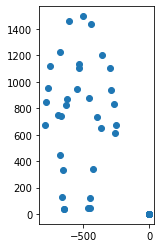

In [133]:
############### Safe to delete this code now. See dataloader below ###################

def c3d2array(loc: str):
    """
    Takes in the file location of the c3d file as a string and returns a 
    numpy array w/ the sensor data
    Array Shape: Num_frames x 43 x 3 
      43 corresponds to the number of nodes on the person
      3 corresponds to spatial coordinates of the nodes
    """
    point_series = []
    reader = c3d.Reader(open(loc, 'rb'))
    for i, points, analog in reader.read_frames():     
        if i % 22 == 0: ## Set Frame Rate to approximately 22 Hz instead of 480 Hz
            point_series.append(points[:, 0:3])
    point_series = np.array(point_series)
    return point_series

## Some funny data visualization L0L
## the x-coordinate represents the width of the person (shoulder to shouler)
## the y-coordinate represents the depth of the person
## the z-coordinate represents the height of the person   
## There is a point at (0, 0, 0) for all the samples for callibration purposes    
test = c3d2array(data_dir + '/Mocap/OpticalData/moc_s01_a02_r01.c3d')
frame = 30
xs, ys, zs = test[frame, :, 0], test[frame, :, 1], test[frame, :, 2]
plt.scatter(xs, zs)
plt.axis('scaled')

In [134]:
################ Dataloader for Berkeley Mocap Optical Data #################

def c3d2array(loc: str, frame_rate):
    """
    Takes in the file location of the c3d file as a string and returns a 
    numpy array w/ the sensor data
    Array Shape: Num_frames x 43 x 3 
      43 corresponds to the number of nodes on the person
      3 corresponds to spatial coordinates of the nodes
    """
    point_series = []
    reader = c3d.Reader(open(loc, 'rb'))
    for i, points, analog in reader.read_frames():     
        if i % frame_rate == 0: ## Set Frame Rate to approximately 22 Hz instead of 480 Hz
            point_series.append(points[:, 0:3])
    point_series = np.array(point_series)
    return point_series

class BerkeleyMocapOpticalDataset(Dataset):
    """Berkeley Mocap Optical Dataset."""

    def __init__(self, root_dir, frame_rate, transform=None):
        """
        Args:
            root_dir (string): Directory with all the data
            frame_rate (integer): In Hz 
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.list_c3d = [file for file in os.listdir(root_dir) if (os.path.isfile(os.path.join(root_dir, file)) and file[-1] != 't' ) ] #list of all the c3d file names
        self.frame_rate = frame_rate
        self.transform = transform

    def __len__(self):
        return len(self.list_c3d)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        c3d_file_location = os.path.join(self.root_dir,
                                self.list_c3d[idx])
        sample = c3d2array(c3d_file_location, self.frame_rate)
        label_location = c3d_file_location.find('_a')
        if label_location == -1: # FUCK T-POSE
            label = 12
        else: 
            label = int(c3d_file_location[label_location+2:label_location+4])
        if self.transform:
            sample = self.transform(sample)
        # Reshape Samples, might want to include this in the transform 
        sample = torch.transpose(sample, 0, 1)
        sample = torch.flatten(sample, 1, 2)
        sample = torch.unsqueeze(sample, 0)
        sample = sample.float()
        return sample, label


############### Compute Mean and SD across the dataset #############
transform = None
root_dir = data_dir + 'Mocap/OpticalData'
"""
frame_rate = 1

dataloader = BerkeleyMocapOpticalDataset(root_dir, 1)
x_list = []
y_list = []
z_list = []

for sample in dataloader:
  x_list.append(np.ndarray.flatten(sample[:,:,0]))
  y_list.append(np.ndarray.flatten(sample[:,:,1]))
  z_list.append(np.ndarray.flatten(sample[:,:,2]))

x_list = np.concatenate(np.array(x_list))
y_list = np.concatenate(np.array(y_list))
z_list = np.concatenate(np.array(z_list))
x_mean = np.mean(x_list)
x_sd = np.std(x_list)
y_mean = np.mean(y_list)
y_sd = np.std(y_list)
z_mean = np.mean(z_list)
z_sd = np.std(z_list)
"""

############### Define a transform with mean, std, and tensor ############
## So we don't need to rerun for the mean and standard deviations every time
x_mean, x_sd, y_mean, y_sd, z_mean, z_sd = -459.35840376604654, 
                                            244.8145592948814, 
                                            137.52356909040483, 
                                            179.76890675731673, 
                                            812.9326420339114, 
                                            532.8888533425072
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((x_mean, y_mean, z_mean), (x_sd, y_sd, z_sd)),
])


############# Final Dataloader ####################
dataloader = BerkeleyMocapOpticalDataset(root_dir, 22, transform=transform)

In [135]:
############ Test Dataloader ######################
## Not working right now since I changed the dataloader
i = 3
for sample in dataloader:
  if i == 0:
    break
  i = i - 1
  frame = 1
  xs, ys, zs = sample[0, frame, :], sample[1, frame, :], sample[2, frame, :]
  plt.figure()
  plt.scatter(xs, zs)
  plt.axis('scaled')
  xs, ys, zs = sample[0, frame+10, :], sample[1, frame+10, :], sample[2, frame+10, :]
  plt.scatter(xs, zs)
  plt.axis('scaled')

TypeError: ignored

In [136]:
class skeletonLSTM(nn.Module):
    def __init__(self, classes):
        super(skeletonLSTM, self).__init__()
        self.n_hidden = 100
        self.n_layers = 1
        self.l_lstm = torch.nn.LSTM(input_size = 129, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, classes)
        self.relu = nn.ReLU()
    def forward(self, x):
        #intialize lstm hidden state
        hidden_state = torch.zeros(self.n_layers, 1, self.n_hidden)
        cell_state = torch.zeros(self.n_layers, 1, self.n_hidden)
        self.hidden = (hidden_state, cell_state)      
        #print(x.shape)
        lstm_out, _ = self.l_lstm(x, self.hidden) #lstm_out shape is batch_size, seq len, hidden state
        lstm_out = lstm_out[:,-1,:]
        lstm_out = self.relu(self.fc1(lstm_out.squeeze()))
        lstm_out = self.fc2(lstm_out)
        return lstm_out
    

In [138]:
 num_epochs = 5
 num_classes = 12
 model = skeletonLSTM(12)
 loss_func = nn.CrossEntropyLoss()
 optimizer = torch.optim.Adam(model.parameters())
 
 for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    for inputs, labels in dataloader:
          model.train()
          if labels == 12: #FUCK T-POSE
              continue
          labels = torch.Tensor([labels])
          predictions = model(inputs).unsqueeze(0)
          loss = loss_func(predictions, labels.long())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


EPOCH 1 of 5


EPOCH 2 of 5


EPOCH 3 of 5


EPOCH 4 of 5


EPOCH 5 of 5



In [139]:
## Just looking at the predictions vs the true labels
for i in range(600):
    sample, label = dataloader[i][0], dataloader[i][1]
    print(torch.argmax(model(sample)), label)

tensor(2) 1
tensor(5) 1
tensor(7) 1
tensor(5) 1
tensor(7) 1
tensor(5) 2
tensor(6) 2
tensor(1) 2
tensor(1) 2
tensor(6) 2
tensor(6) 3
tensor(6) 3
tensor(6) 3
tensor(6) 3
tensor(6) 3
tensor(7) 4
tensor(7) 4
tensor(7) 4
tensor(6) 4
tensor(7) 4
tensor(5) 5
tensor(5) 5
tensor(5) 5
tensor(5) 5
tensor(5) 5
tensor(6) 6
tensor(6) 6
tensor(6) 6
tensor(6) 6
tensor(6) 6
tensor(7) 7
tensor(7) 7
tensor(7) 7
tensor(7) 7
tensor(7) 7
tensor(8) 8
tensor(8) 8
tensor(8) 8
tensor(8) 8
tensor(1) 8
tensor(9) 9
tensor(9) 9
tensor(9) 9
tensor(9) 9
tensor(9) 9
tensor(10) 10
tensor(10) 10
tensor(10) 10
tensor(10) 10
tensor(10) 10
tensor(9) 11
tensor(9) 11
tensor(9) 11
tensor(9) 11
tensor(9) 11
tensor(1) 1
tensor(7) 1
tensor(1) 1
tensor(1) 1
tensor(4) 1
tensor(5) 2
tensor(5) 2
tensor(5) 2
tensor(6) 2
tensor(5) 2
tensor(5) 3
tensor(6) 3
tensor(5) 3
tensor(6) 3
tensor(6) 3
tensor(4) 4
tensor(7) 4
tensor(4) 4
tensor(4) 4
tensor(7) 4
tensor(5) 5
tensor(5) 5
tensor(5) 5
tensor(5) 5
tensor(5) 5
tensor(5) 6
tensor(5) 6
t

KeyboardInterrupt: ignored

#LSTM on Image Data

In [ ]:
X = []
subjects = ['S03', 'S04', 'S05','S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12']
actions = ['A03', 'A04', 'A05','A06', 'A07', 'A08', 'A09', 'A10', 'A11']
for i, action in enumerate(actions):
    for subject in subjects:
        for repeat in reps:
            if subject == 'S04' and action == 'A04' and repeat == 'R05':
              continue
            if subject == 'S01' or subject == 'S02':
              continue
            if subject == 'S03' and action == 'A01':
              continue
            if subject == 'S03' and action == 'A02':
              continue
            image_path = data_dir + 'Camera/Cluster01/Cam01/' + str(subject) + '/' + str(action) + '/' + str(repeat) + '/'
            dirs = os.listdir(image_path)
            sample = []
            for dir in dirs:
                sample.append(ndimage.zoom(pcv.readbayer(image_path + dir, bayerpattern='GR')[0][:,120:480], [1/2, 1/2, 1]))
            #X.append(np.array(sample))
            np.savez("/content/gdrive/My Drive/rgb_video_data/" + str(subject) + '_' + str(action) + '_' + str(repeat), x=np.array(sample), y=i)
    


In [ ]:
class BerkeleyMHAD(Dataset):

    def __init__(self, vid_names, root_dir, transform=None):
        self.vid_names = vid_names # list of file names for videos (ex. S01_A01_R01)
        self.root_dir = root_dir # directory where videos are stored
        self.transform = transform

    def __len__(self):
        return len(self.vid_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path = os.path.join(self.root_dir, self.vid_names[idx])
        x = np.load(path)['x']
        label = np.load(path)['y']
        sample = {'x': x, 'y': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
data_dir = "/content/gdrive/My Drive/dl_proj_data"
mhad_dataset = BerkeleyMHAD(vid_names=os.listdir(data_dir), root_dir=data_dir)

In [ ]:
sample = mhad_dataset[2]
sample

{'x': array([[[ 17,  17,  17, ...,  54,  48,  55],
         [ 16,  20,  20, ...,  51,  38,  48],
         [ 25,  23,  23, ...,  55,  52,  50],
         ...,
         [ 35, 103,  32, ...,  67,  64, 115],
         [162, 148, 111, ...,  63,  96, 118],
         [ 33, 160,  37, ...,  66,  61, 114]],
 
        [[ 16,  16,  17, ...,  54,  51,  53],
         [ 16,  19,  18, ...,  49,  39,  51],
         [ 23,  24,  25, ...,  54,  51,  53],
         ...,
         [ 38, 100,  28, ...,  66,  62, 112],
         [157, 149, 109, ...,  63,  93, 121],
         [ 33, 163,  36, ...,  64,  58, 112]],
 
        [[ 16,  17,  17, ...,  53,  51,  53],
         [ 17,  20,  20, ...,  50,  38,  50],
         [ 23,  25,  23, ...,  55,  52,  55],
         ...,
         [ 36,  97,  31, ...,  69,  60, 115],
         [157, 149, 110, ...,  65,  93, 121],
         [ 36, 156,  37, ...,  66,  56, 114]],
 
        ...,
 
        [[ 15,  17,  17, ...,  52,  50,  53],
         [ 17,  20,  17, ...,  50,  39,  49],
         